### Прогнозирование температуры звезды

Задача от обсерватории: придумать, как с помощью нейросети определять температуру на поверхности обнаруженных звёзд. Обычно для расчёта температуры учёные пользуются следующими методами:

- Закон смещения Вина.
- Закон Стефана-Больцмана.
- Спектральный анализ.

Каждый из них имеет плюсы и минусы. Обсерватория хочет внедрить технологии машинного обучения для предсказания температуры звёзд, надеясь, что этот метод будет наиболее точным и удобным.
В базе обсерватории есть характеристики уже изученных 240 звёзд.

## Загрузка данных

In [1]:
!pip install -U scorch

In [2]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import random
import math

from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
#from torchmetrics import MeanSquaredError
from math import ceil

import torch
import torch.nn as nn

import scorch
from skorch import NeuralNetRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer

In [3]:
STATE = 12345

In [4]:
# ming xing - яркая звезда, по китайски.
ming_xing = pd.read_csv('/datasets/6_class.csv')

In [5]:
ming_xing

,Unnamed: 0,Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star type,Star color
0,0,3068,0.002400,0.1700,16.12,0,Red
1,1,3042,0.000500,0.1542,16.60,0,Red
2,2,2600,0.000300,0.1020,18.70,0,Red
3,3,2800,0.000200,0.1600,16.65,0,Red
4,4,1939,0.000138,0.1030,20.06,0,Red
...,...,...,...,...,...,...,...
235,235,38940,374830.000000,1356.0000,-9.93,5,Blue
236,236,30839,834042.000000,1194.0000,-10.63,5,Blue
237,237,8829,537493.000000,1423.0000,-10.73,5,White
238,238,9235,404940.000000,1112.0000,-11.23,5,White


In [6]:
ming_xing.columns

Index(['Unnamed: 0', 'Temperature (K)', 'Luminosity(L/Lo)', 'Radius(R/Ro)',
       'Absolute magnitude(Mv)', 'Star type', 'Star color'],
      dtype='object')

In [7]:
columns_ren = ['Unnamed: 0', 'temperature_k', 'luminosity_l_lo', 'radius_r_ro',
       'abs_magnitude_mv', 'star_type', 'star_color']

In [8]:
ming_xing.columns = columns_ren

In [9]:
ming_xing = ming_xing.drop('Unnamed: 0', axis=1)

In [10]:
ming_xing.head()

,temperature_k,luminosity_l_lo,radius_r_ro,abs_magnitude_mv,star_type,star_color
0,3068,0.002400,0.1700,16.12,0,Red
1,3042,0.000500,0.1542,16.60,0,Red
2,2600,0.000300,0.1020,18.70,0,Red
3,2800,0.000200,0.1600,16.65,0,Red
4,1939,0.000138,0.1030,20.06,0,Red


In [11]:
#функция для расчета температуры звезды через закон Стефана-Больцмана

def T_bolcman(row):
    sigma = 5.056e-8
    L = row['luminosity_l_lo']*3.828*10e26
    R = row['radius_r_ro']*6.9551*10e8
    
    T = (L / (4*3.1415*R*R*sigma))**0.25 #расчёт температуры через закон Стефана-Больцмана
    
    return T

In [12]:
ming_xing['t_bolcman'] = ming_xing.apply(T_bolcman, axis=1)

In [13]:
ming_xing

,temperature_k,luminosity_l_lo,radius_r_ro,abs_magnitude_mv,star_type,star_color,t_bolcman
0,3068,0.002400,0.1700,16.12,0,Red,1793.364682
1,3042,0.000500,0.1542,16.60,0,Red,1272.156605
2,2600,0.000300,0.1020,18.70,0,Red,1376.640337
3,2800,0.000200,0.1600,16.65,0,Red,993.202423
4,1939,0.000138,0.1030,20.06,0,Red,1128.213838
...,...,...,...,...,...,...,...
235,38940,374830.000000,1356.0000,-9.93,5,Blue,2244.755290
236,30839,834042.000000,1194.0000,-10.63,5,Blue,2921.696361
237,8829,537493.000000,1423.0000,-10.73,5,White,2397.899714
238,9235,404940.000000,1112.0000,-11.23,5,White,2527.176293


In [14]:
mean_squared_error(ming_xing['temperature_k'], ming_xing['t_bolcman'], squared=False)

8917.686056513578

RMSE рассчитанная через закон Стефана-Больцмана для всего датасета составляет около 9000

##### поиск солнца

In [16]:
#поиск солнца по радиусу
ming_xing.loc[np.isclose(ming_xing['radius_r_ro'], 1.0, atol=1e-3)]

,temperature_k,luminosity_l_lo,radius_r_ro,abs_magnitude_mv,star_type,star_color,t_bolcman


солнца в таблице нет

In [17]:
#поиск солнца по относительной светимости
ming_xing.loc[np.isclose(ming_xing['luminosity_l_lo'], 1.0, atol=1e-3)]

,temperature_k,luminosity_l_lo,radius_r_ro,abs_magnitude_mv,star_type,star_color,t_bolcman


In [18]:
ming_xing.query('0.8 < luminosity_l_lo < 1.4')

,temperature_k,luminosity_l_lo,radius_r_ro,abs_magnitude_mv,star_type,star_color,t_bolcman
34,5800,0.810,0.900,5.05,3,yellow-white,3340.721429
37,6380,1.350,0.980,2.93,3,yellow-white,3637.564201
38,5936,1.357,1.106,4.46,3,yellow-white,3428.527689
39,5587,0.819,0.990,5.03,3,yellow-white,3194.064199


Небольшая проверка показала что звезды `солнце` в таблице нет.

In [19]:
ming_xing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240 entries, 0 to 239
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   temperature_k     240 non-null    int64  
 1   luminosity_l_lo   240 non-null    float64
 2   radius_r_ro       240 non-null    float64
 3   abs_magnitude_mv  240 non-null    float64
 4   star_type         240 non-null    int64  
 5   star_color        240 non-null    object 
 6   t_bolcman         240 non-null    float64
dtypes: float64(4), int64(2), object(1)
memory usage: 13.2+ KB


## Предобработка и анализ данных

In [20]:
# проверка полных дубликатов строк.
ming_xing.duplicated().sum()

0

In [21]:
#дополнительная проверка на наличие пустых значений
ming_xing.isna().sum()

temperature_k       0
luminosity_l_lo     0
radius_r_ro         0
abs_magnitude_mv    0
star_type           0
star_color          0
t_bolcman           0
dtype: int64

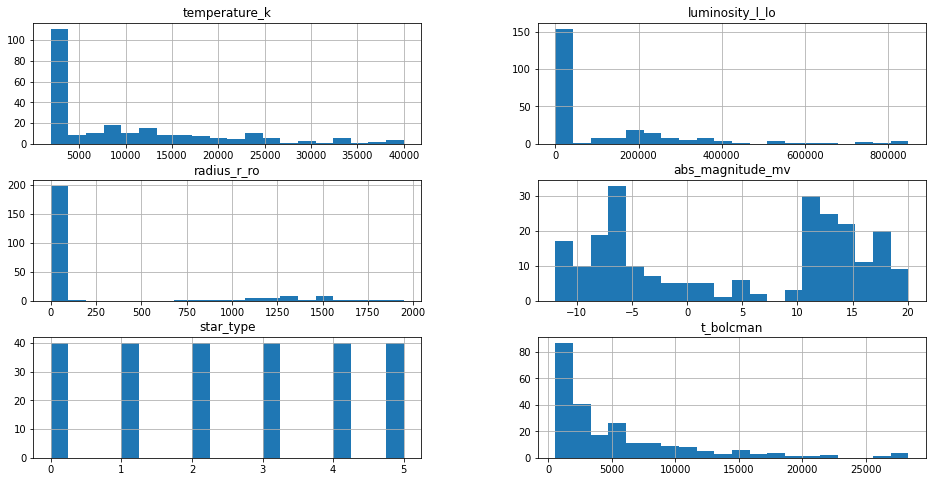

In [22]:
ming_xing.hist(bins=20, figsize=(16,8))
None

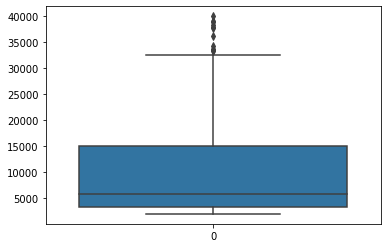

In [23]:
sns.boxplot(data=ming_xing['temperature_k'])
plt.show() 

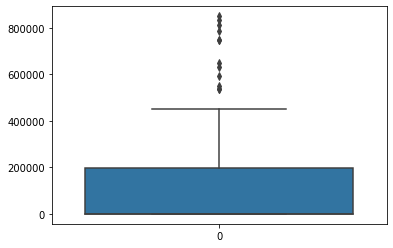

In [24]:
sns.boxplot(data=ming_xing['luminosity_l_lo']);

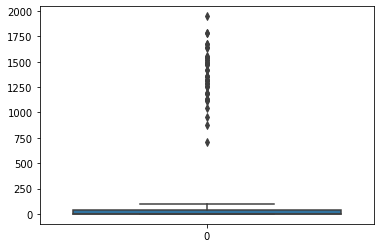

In [25]:
sns.boxplot(data=ming_xing['radius_r_ro']);

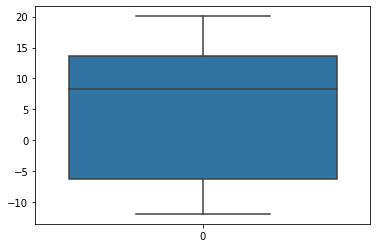

In [26]:
sns.boxplot(data=ming_xing['abs_magnitude_mv']);

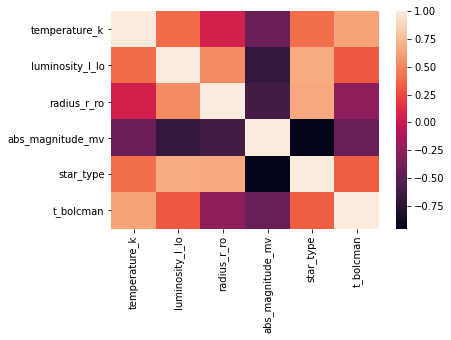

In [27]:
sns.heatmap(ming_xing.corr());

In [28]:
ming_xing.describe()

,temperature_k,luminosity_l_lo,radius_r_ro,abs_magnitude_mv,star_type,t_bolcman
count,240.000000,240.000000,240.000000,240.000000,240.000000,240.000000
mean,10497.462500,107188.361635,237.157781,4.382396,2.500000,5458.283491
std,9552.425037,179432.244940,517.155763,10.532512,1.711394,5688.512933
min,1939.000000,0.000080,0.008400,-11.920000,0.000000,559.172895
25%,3344.250000,0.000865,0.102750,-6.232500,1.000000,1653.402161
50%,5776.000000,0.070500,0.762500,8.313000,2.500000,2818.654889
75%,15055.500000,198050.000000,42.750000,13.697500,4.000000,7228.703853
max,40000.000000,849420.000000,1948.500000,20.060000,5.000000,28351.855025


In [29]:
ming_xing['star_type'].value_counts()

0    40
1    40
2    40
3    40
4    40
5    40
Name: star_type, dtype: int64

In [30]:
ming_xing['star_type'].unique()

array([0, 1, 2, 3, 4, 5])

In [31]:
ming_xing['star_color'].value_counts()

Red                   112
Blue                   55
Blue-white             26
Blue White             10
yellow-white            8
White                   7
Yellowish White         3
white                   3
Blue white              3
Whitish                 2
Orange                  2
yellowish               2
Blue-White              1
Blue white              1
White-Yellow            1
Yellowish               1
Orange-Red              1
Blue                    1
Pale yellow orange      1
Name: star_color, dtype: int64

In [32]:
ming_xing['star_color'].unique()

array(['Red', 'Blue White', 'White', 'Yellowish White', 'Blue white',
       'Pale yellow orange', 'Blue', 'Blue-white', 'Whitish',
       'yellow-white', 'Orange', 'White-Yellow', 'white', 'Blue ',
       'yellowish', 'Yellowish', 'Orange-Red', 'Blue white ',
       'Blue-White'], dtype=object)

Очевидно что есть одинаковые значения, но написанные по разному.

In [33]:
#перевод всех значений столбца star_color в нижний регистр,удаление первого и последнего пробела
ming_xing['star_color'] = ming_xing['star_color'].str.lower().str.strip()

In [34]:
ming_xing['star_color'].unique()

array(['red', 'blue white', 'white', 'yellowish white',
       'pale yellow orange', 'blue', 'blue-white', 'whitish',
       'yellow-white', 'orange', 'white-yellow', 'yellowish',
       'orange-red'], dtype=object)

Насколько так можно делать не знаю, стоит проконсультироваться с астрономами, но произведу укрупнение групп.

То есть близкие названия заменю на одинаковые. Тем более что данных не много, всего 240 записей

Например `white` и `whitish` это одна группа, `yellowish white` `yellow-white` `white-yellow` это тоже она группа

In [35]:
#функция для замены названий в ячейках
def repl(x):
    if x == 'blue white': x = 'blue_white'
    if x == 'blue-white': x = 'blue_white'
    if x == 'whitish': x = 'white'
    if x == 'yellowish white': x = 'yellow_white'
    if x == 'white-yellow': x = 'yellow_white'
    if x == 'white-yellow': x = 'yellow_white'
    if x == 'white-yellow': x = 'yellow_white'
    if x == 'yellow-white': x = 'yellow_white'
    if x == 'pale yellow orange': x = 'orange'
    if x == 'orange-red': x = 'yellow'
    if x == 'yellowish': x = 'yellow'
    if x == 'orange': x = 'yellow'
        
    return x

In [36]:
ming_xing['star_color'] = ming_xing['star_color'].apply(repl)

In [37]:
#проверка
ming_xing['star_color'].unique()

array(['red', 'blue_white', 'white', 'yellow_white', 'yellow', 'blue'],
      dtype=object)

In [38]:
#проверка
ming_xing['star_color'].value_counts()

red             112
blue             56
blue_white       41
yellow_white     12
white            12
yellow            7
Name: star_color, dtype: int64

### выводы

Датафрейм небольшой, всего 240 строк и 5 столбцов

Не имеет пропусков в колонках и дублирования строк.

Численные данные хоть и имеют сильный разброс, но не имеют неадекватных выбросов. 

Категориальные данные (столбец `star_type`) равномерно распределены и не нуждаются в доработке.

Столбец `star_color` имел много близких по названию значений. Произведено сокращение групп.

Все численные столбцы не имеют нормального распределения.

RMSE температуры звезд, рассчитанная через закон Стефана-Больцмана, для всего датасета, составляет около 9000 К.

In [39]:
ming_xing.columns

Index(['temperature_k', 'luminosity_l_lo', 'radius_r_ro', 'abs_magnitude_mv',
       'star_type', 'star_color', 't_bolcman'],
      dtype='object')

In [40]:
#списки числовых столбцов и категориальных
#температура поверхности 'temperature_k' не включена в численные столбцы
num_col = ['luminosity_l_lo', 'radius_r_ro', 'abs_magnitude_mv']
cat_col = ['star_type', 'star_color']

In [41]:
#разделение датасета на обучающую часть и тестовую
y = ming_xing['temperature_k']
x = ming_xing.drop(['temperature_k', 't_bolcman'], axis=1)

x_train, x_test, y_train, y_test = train_test_split(
    x, 
    y, 
    test_size=0.3, 
    shuffle=True,
    random_state=STATE)

In [42]:
x_train = x_train.reset_index(drop=True)
x_test = x_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

In [43]:
x_train.shape

(168, 5)

In [44]:
x_train.head()

,luminosity_l_lo,radius_r_ro,abs_magnitude_mv,star_type,star_color
0,131000.000000,24.0000,-7.22,4,blue
1,404940.000000,1112.0000,-11.23,5,white
2,0.000551,0.0998,16.67,0,red
3,0.000450,0.0109,13.98,2,blue_white
4,452000.000000,83.0000,-5.62,4,blue


In [45]:
y_train.shape

(168,)

In [46]:
y_train.head()

0     7282
1     9235
2     3484
3     9675
4    12675
Name: temperature_k, dtype: int64

In [47]:
x_test.shape

(72, 5)

In [48]:
x_test.head()

,luminosity_l_lo,radius_r_ro,abs_magnitude_mv,star_type,star_color
0,648430.0,1948.50,-10.840,5,blue
1,204000.0,10.60,-4.700,3,blue
2,29.0,1.91,1.236,3,blue_white
3,272000.0,1183.00,-9.200,5,red
4,45.0,2.63,1.450,3,blue_white


In [49]:
y_test.shape

(72,)

In [50]:
y_test.head()

0    32489
1    39000
2     9320
3     3834
4     9030
Name: temperature_k, dtype: int64

Разделилось всё верно.

In [51]:
#преобразование категориальных столбцов техникой OHE
ohe = OneHotEncoder()

In [52]:
#преобразование числовых данных в диапазон [0, 1]
min_max_scaler = MinMaxScaler()

In [53]:
#преобразование числовых столбцов MinMaxScaler
x_train[num_col] = min_max_scaler.fit_transform(x_train[num_col])

In [54]:
#обучение OneHotEncoder на категориальных столбцах
ohe.fit(x_train[cat_col])

OneHotEncoder()

In [55]:
x_train

,luminosity_l_lo,radius_r_ro,abs_magnitude_mv,star_type,star_color
0,1.611316e-01,0.013456,0.142408,4,blue
1,4.980812e-01,0.623666,0.016347,5,white
2,5.793358e-10,0.000051,0.893430,0,red
3,4.551046e-10,0.000001,0.808865,2,blue_white
4,5.559656e-01,0.046546,0.192707,4,blue
...,...,...,...,...,...
163,2.939729e-01,0.019625,0.138636,4,blue
164,4.391144e-10,0.000043,0.938070,0,red
165,0.000000e+00,0.000002,0.812009,2,yellow
166,9.211439e-01,0.051594,0.138447,4,blue


In [56]:
x_train[num_col].describe()

,luminosity_l_lo,radius_r_ro,abs_magnitude_mv
count,1.680000e+02,168.000000,168.000000
mean,1.267120e-01,0.115053,0.525174
std,2.144878e-01,0.266701,0.334165
min,0.000000e+00,0.000000,0.000000
25%,7.687577e-10,0.000050,0.173672
50%,1.047970e-08,0.000265,0.708897
75%,2.398524e-01,0.020186,0.810594
max,1.000000e+00,1.000000,1.000000


Преобразовалось верно. Минимальное значение 0, максимальное 1.

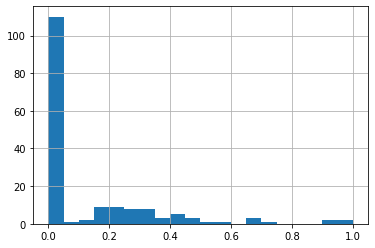

In [57]:
x_train.luminosity_l_lo.hist(bins=20);

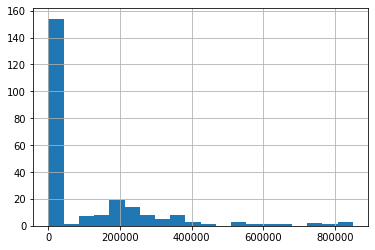

In [58]:
ming_xing.luminosity_l_lo.hist(bins=20);

In [59]:
x_train_ohe = x_train[num_col].join(pd.DataFrame(ohe.transform(x_train[cat_col]).toarray()))

In [60]:
x_train_ohe

,luminosity_l_lo,radius_r_ro,abs_magnitude_mv,0,1,2,3,4,5,6,7,8,9,10,11
0,1.611316e-01,0.013456,0.142408,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,4.980812e-01,0.623666,0.016347,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
2,5.793358e-10,0.000051,0.893430,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,4.551046e-10,0.000001,0.808865,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,5.559656e-01,0.046546,0.192707,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163,2.939729e-01,0.019625,0.138636,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
164,4.391144e-10,0.000043,0.938070,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
165,0.000000e+00,0.000002,0.812009,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
166,9.211439e-01,0.051594,0.138447,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


##### преобразование столбцов тестовой выборки (MinMaxScaler и OHE)

In [61]:
x_test[num_col] = min_max_scaler.transform(x_test[num_col])

In [62]:
x_test

,luminosity_l_lo,radius_r_ro,abs_magnitude_mv,star_type,star_color
0,7.975769e-01,1.092822e+00,0.028607,5,blue
1,2.509225e-01,5.940186e-03,0.221628,3,blue
2,3.567026e-05,1.066354e-03,0.408236,3,blue_white
3,3.345633e-01,6.634869e-01,0.080163,5,red
4,5.535046e-05,1.470170e-03,0.414964,3,blue_white
...,...,...,...,...,...
67,6.543665e-09,1.740334e-04,0.760138,1,red
68,4.464945e-01,9.383059e-01,-0.005344,5,red
69,8.979090e-10,5.608552e-07,0.815781,2,blue_white
70,3.222632e-09,3.708936e-04,0.799025,1,red


In [63]:
x_test[num_col].describe()

,luminosity_l_lo,radius_r_ro,abs_magnitude_mv
count,7.200000e+01,7.200000e+01,72.000000
mean,1.438154e-01,1.748966e-01,0.465089
std,2.356935e-01,3.366709e-01,0.322224
min,3.690037e-11,-1.682566e-07,-0.005344
25%,1.798893e-09,7.223815e-05,0.167557
50%,4.120531e-05,1.233769e-03,0.391323
75%,2.460025e-01,3.981584e-02,0.747014
max,1.044797e+00,1.092822e+00,0.998743


Тестовая выборка так же преобразовалась в диапазон 0...1

In [64]:
x_test_ohe = x_test[num_col].join(pd.DataFrame(ohe.transform(x_test[cat_col]).toarray()))

In [65]:
x_test_ohe

,luminosity_l_lo,radius_r_ro,abs_magnitude_mv,0,1,2,3,4,5,6,7,8,9,10,11
0,7.975769e-01,1.092822e+00,0.028607,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
1,2.509225e-01,5.940186e-03,0.221628,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,3.567026e-05,1.066354e-03,0.408236,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,3.345633e-01,6.634869e-01,0.080163,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
4,5.535046e-05,1.470170e-03,0.414964,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67,6.543665e-09,1.740334e-04,0.760138,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
68,4.464945e-01,9.383059e-01,-0.005344,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
69,8.979090e-10,5.608552e-07,0.815781,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
70,3.222632e-09,3.708936e-04,0.799025,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


###### преобразование категориальных столбцов техникой Ordinal Encoder

In [66]:
x_train.columns

Index(['luminosity_l_lo', 'radius_r_ro', 'abs_magnitude_mv', 'star_type',
       'star_color'],
      dtype='object')

In [67]:
#
col_oe = ['star_type', 'star_color']

In [68]:
oe = OrdinalEncoder()

In [69]:
x_train_oe =  x_train[num_col].join(pd.DataFrame(oe.fit_transform(x_train[col_oe]), columns=col_oe))

In [70]:
x_train_oe

,luminosity_l_lo,radius_r_ro,abs_magnitude_mv,star_type,star_color
0,1.611316e-01,0.013456,0.142408,4.0,0.0
1,4.980812e-01,0.623666,0.016347,5.0,3.0
2,5.793358e-10,0.000051,0.893430,0.0,2.0
3,4.551046e-10,0.000001,0.808865,2.0,1.0
4,5.559656e-01,0.046546,0.192707,4.0,0.0
...,...,...,...,...,...
163,2.939729e-01,0.019625,0.138636,4.0,0.0
164,4.391144e-10,0.000043,0.938070,0.0,2.0
165,0.000000e+00,0.000002,0.812009,2.0,4.0
166,9.211439e-01,0.051594,0.138447,4.0,0.0


In [71]:
x_train_oe[num_col].describe()

,luminosity_l_lo,radius_r_ro,abs_magnitude_mv
count,1.680000e+02,168.000000,168.000000
mean,1.267120e-01,0.115053,0.525174
std,2.144878e-01,0.266701,0.334165
min,0.000000e+00,0.000000,0.000000
25%,7.687577e-10,0.000050,0.173672
50%,1.047970e-08,0.000265,0.708897
75%,2.398524e-01,0.020186,0.810594
max,1.000000e+00,1.000000,1.000000


##### преобразование столбцов тестовой выборки (MinMaxScaler и Ordinal Encoder)

In [72]:
x_test_oe =  x_test[num_col].join(pd.DataFrame(oe.transform(x_test[col_oe]), columns=col_oe))

In [73]:
x_test_oe

,luminosity_l_lo,radius_r_ro,abs_magnitude_mv,star_type,star_color
0,7.975769e-01,1.092822e+00,0.028607,5.0,0.0
1,2.509225e-01,5.940186e-03,0.221628,3.0,0.0
2,3.567026e-05,1.066354e-03,0.408236,3.0,1.0
3,3.345633e-01,6.634869e-01,0.080163,5.0,2.0
4,5.535046e-05,1.470170e-03,0.414964,3.0,1.0
...,...,...,...,...,...
67,6.543665e-09,1.740334e-04,0.760138,1.0,2.0
68,4.464945e-01,9.383059e-01,-0.005344,5.0,2.0
69,8.979090e-10,5.608552e-07,0.815781,2.0,1.0
70,3.222632e-09,3.708936e-04,0.799025,1.0,2.0


In [74]:
x_test_oe[num_col].describe()

,luminosity_l_lo,radius_r_ro,abs_magnitude_mv
count,7.200000e+01,7.200000e+01,72.000000
mean,1.438154e-01,1.748966e-01,0.465089
std,2.356935e-01,3.366709e-01,0.322224
min,3.690037e-11,-1.682566e-07,-0.005344
25%,1.798893e-09,7.223815e-05,0.167557
50%,4.120531e-05,1.233769e-03,0.391323
75%,2.460025e-01,3.981584e-02,0.747014
max,1.044797e+00,1.092822e+00,0.998743


В итоге получил два типа датасета: 

    - обучающая и тестовая выборки кодированные MinMaxScaler и OHE.
    - обучающая и тестовая выборки кодированные MinMaxScaler и Ordinal Encoder

## Построение базовой нейронной сети

In [75]:
x_train_ohe.shape, y_train.shape, x_test_ohe.shape, y_test.shape

((168, 15), (168,), (72, 15), (72,))

In [76]:
x_train_oe.shape, y_train.shape, x_test_oe.shape, y_test.shape

((168, 5), (168,), (72, 5), (72,))

In [77]:
x_train = torch.FloatTensor(x_train_ohe.values)
x_test = torch.FloatTensor(x_test_ohe.values)
y_train = torch.FloatTensor(y_train.values)
y_test = torch.FloatTensor(y_test.values)

В дальнейшем используются данные преобразованные с помощью OrdinalEncoder.

Практика показала что результат не зависит от типа преобразования.

In [78]:
random.seed(STATE)
np.random.seed(STATE)
torch.manual_seed(STATE)
torch.use_deterministic_algorithms(True)

In [79]:
class Net(nn.Module):
    def __init__(self, n_in_neurons, n_hidden_neurons_1,
                 n_hidden_neurons_2, n_hidden_neurons_3, 
                 n_out_neurons):
        super(Net, self).__init__()

        self.fc1 = nn.Linear(n_in_neurons, n_hidden_neurons_1)
        self.act1 = nn.ReLU()
        
        self.fc2 = nn.Linear(n_hidden_neurons_1, n_hidden_neurons_2)
        self.act2 = nn.ELU()
        #self.act2 = nn.ReLU()
        
        self.fc3 = nn.Linear(n_hidden_neurons_2, n_hidden_neurons_3)
        self.act3 = nn.ELU()
        #self.act3 = nn.ReLU()
        
        self.fc4 = nn.Linear(n_hidden_neurons_3, n_out_neurons)
        self.act4 = nn.ReLU()
        
        nn.init.kaiming_uniform_(self.fc1.weight, mode='fan_in', nonlinearity='relu')
        nn.init.normal_(self.fc1.bias, mean=0.2, std=0.5)
        
        nn.init.kaiming_uniform_(self.fc2.weight, mode='fan_in', nonlinearity='relu')
        nn.init.normal_(self.fc2.bias, mean=0.2, std=0.5)
        
        nn.init.kaiming_uniform_(self.fc3.weight, mode='fan_in', nonlinearity='relu')
        nn.init.normal_(self.fc3.bias, mean=0.0, std=1.0)
        
        nn.init.kaiming_uniform_(self.fc4.weight, mode='fan_in', nonlinearity='relu')
        nn.init.normal_(self.fc4.bias, mean=2, std=2)
  
        

    def forward(self, x):
        x = self.fc1(x)
        x = self.act1(x)
        
        x = self.fc2(x)
        x = self.act2(x)
        
        x = self.fc3(x)
        x = self.act3(x)
        
        x = self.fc4(x)
        x = self.act4(x)
            
        return x


In [80]:
n_in_neurons = x_train.shape[1] #количество входов на первый слой
n_hidden_neurons_1 = 32
n_hidden_neurons_2 = 30
n_hidden_neurons_3 = 14
n_out_neurons = 1

In [81]:
#определение сети
net = Net(n_in_neurons, n_hidden_neurons_1, 
          n_hidden_neurons_2, n_hidden_neurons_3, 
          n_out_neurons)

In [82]:
#выборр оптимизатора
optimizer = torch.optim.Adam(net.parameters(), lr=4.0e-3)

In [83]:
#выбор функции потерь MSE
loss = nn.MSELoss()

In [84]:
#количество эпох
num_epochs = 6000

In [85]:
los = []
rms = []
for epoch in range(num_epochs):
    
    optimizer.zero_grad()
    preds = net.forward(x_train).flatten()
    loss_value = loss(preds, y_train)
    loss_value.backward()   
    optimizer.step()
    
    

    if epoch % 100 == 0 or epoch == num_epochs - 1:
        print('loss =', loss_value.item())
        los.append(loss_value.item())
        
        net.eval()
        test_preds = net.forward(x_test)
        
        #rmse_accuracy =  float(rmse_serg(test_preds.flatten(), y_test))
        rmse_accuracy = np.sqrt(mean_squared_error(y_test.detach().numpy(), test_preds.detach().numpy()))
        rms.append(rmse_accuracy)
        print('epoch =', epoch, 'RMSE =', rmse_accuracy)
        print()

loss = 183847184.0
epoch = 0 RMSE = 15514.913

loss = 120564760.0
epoch = 100 RMSE = 12880.638

loss = 33928008.0
epoch = 200 RMSE = 7335.551

loss = 25227958.0
epoch = 300 RMSE = 6140.8096

loss = 21006862.0
epoch = 400 RMSE = 5540.7944

loss = 18398934.0
epoch = 500 RMSE = 5209.3687

loss = 16918168.0
epoch = 600 RMSE = 5050.3228

loss = 16117246.0
epoch = 700 RMSE = 4978.7334

loss = 15733352.0
epoch = 800 RMSE = 4950.0283

loss = 15563802.0
epoch = 900 RMSE = 4941.999

loss = 15448931.0
epoch = 1000 RMSE = 4941.544

loss = 15345853.0
epoch = 1100 RMSE = 4937.5376

loss = 15242219.0
epoch = 1200 RMSE = 4932.1895

loss = 15118807.0
epoch = 1300 RMSE = 4926.532

loss = 14937186.0
epoch = 1400 RMSE = 4907.434

loss = 14711522.0
epoch = 1500 RMSE = 4888.3784

loss = 14455621.0
epoch = 1600 RMSE = 4827.0264

loss = 14152704.0
epoch = 1700 RMSE = 4745.287

loss = 13815526.0
epoch = 1800 RMSE = 4632.8774

loss = 13511828.0
epoch = 1900 RMSE = 4544.906

loss = 13343208.0
epoch = 2000 RMSE =

In [86]:
#вывод коэффициентов сети
for param in net.parameters():
    print(param.mean())

tensor(0.1279, grad_fn=<MeanBackward0>)
tensor(0.7367, grad_fn=<MeanBackward0>)
tensor(0.1921, grad_fn=<MeanBackward0>)
tensor(0.1071, grad_fn=<MeanBackward0>)
tensor(-1.1474, grad_fn=<MeanBackward0>)
tensor(0.4863, grad_fn=<MeanBackward0>)
tensor(2.2386, grad_fn=<MeanBackward0>)
tensor(6.0014, grad_fn=<MeanBackward0>)


In [87]:
#функция для построения графика потерь и ошибки на обучении и на тесте

def show_loss_rmse(rms, los):
    fig, ax1 = plt.subplots()
    ax2 = ax1.twinx()
    ax1.plot(rms, label= 'RMSE_test')
    ax2.plot(los, label = 'y(t)', color='darkred')
    ax1.set_ylabel('RMSE_test', color='b')
    ax2.set_ylabel('loss', color='darkred')
    plt.show()

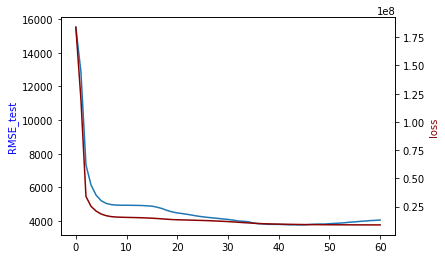

In [88]:
show_loss_rmse(rms, los)

In [89]:
a = test_preds.detach().numpy()  #, y_test)

In [90]:
#предсказания
a = np.resize(a, len(a))

In [91]:
#реальные данные
b = y_test.detach().numpy()

In [92]:
ab = pd.DataFrame({'a': a, 'b': b}, columns=['a', 'b'])

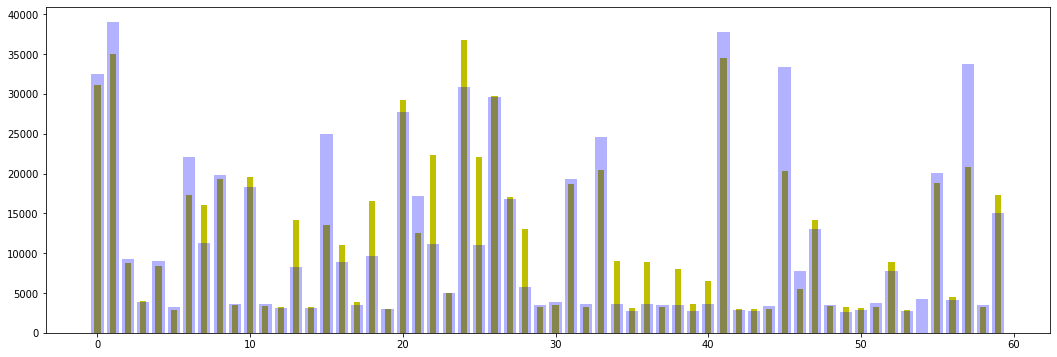

In [93]:
#https://pyprog.pro/mpl/mpl_bar.html

l = 60 # сколько значений взять для графика

fig, ax = plt.subplots()

ax.bar(x=ab.index[:l], height=ab['a'][:l], color = 'y', width = 0.4)
ax.bar(x=ab.index[:l], height=ab['b'][:l], color = 'b', alpha=0.3)

fig.set_figwidth(18)    #  ширина и
fig.set_figheight(6)    #  высота "Figure"
#fig.set_facecolor('floralwhite')
#ax.set_facecolor('seashell')

plt.show()

Синие - реальные данные, Желтые столбцы - предсказанные

#### ВЫВОД

Созданная нейросеть довольно проста и имеет два скрытых слоя. Все функции активации ReLU или ELU.

Примерно на 4000-й эпохе нейросеть выходит на лучшие показатели по RMSE, около 3800.  

Результаты улучшаются если довольно долго подбирать коэффициенты весов при инициализации. 

## Улучшение нейронной сети

In [107]:
class Net2(nn.Module):
    def __init__(self, n_in_neurons, n_hidden_neurons_1,
                 n_hidden_neurons_2, n_hidden_neurons_3, 
                 n_out_neurons, dropout_onoff=False, batchnorm_onoff=False):
        super(Net2, self).__init__()
        
        self.dropout_onoff = False
        self.batchnorm_onoff = False
        
        self.fc1 = nn.Linear(n_in_neurons, n_hidden_neurons_1)
        self.dp1 = nn.Dropout(p=0.2) #дроп аут
        self.bn1 = nn.BatchNorm1d(n_hidden_neurons_1)
        self.act1 = nn.ReLU()

        self.fc2 = nn.Linear(n_hidden_neurons_1, n_hidden_neurons_2)
        self.bn2 = nn.BatchNorm1d(n_hidden_neurons_2)
        self.act2 = nn.ELU()
        
        self.fc3 = nn.Linear(n_hidden_neurons_2, n_hidden_neurons_3)
        self.bn3 = nn.BatchNorm1d(n_hidden_neurons_3)
        self.act3 = nn.ELU()

        self.fc4 = nn.Linear(n_hidden_neurons_3, n_out_neurons)
        self.act4 = nn.ReLU()
        
        #инициализация начальных весов
        nn.init.kaiming_uniform_(self.fc1.weight, mode='fan_in', nonlinearity='relu')
        nn.init.normal_(self.fc1.bias, mean=0.2, std=0.5)
        
        nn.init.kaiming_uniform_(self.fc2.weight, mode='fan_in', nonlinearity='relu')
        nn.init.normal_(self.fc2.bias, mean=0.2, std=0.5)
        
        nn.init.kaiming_uniform_(self.fc3.weight, mode='fan_in', nonlinearity='relu')
        nn.init.normal_(self.fc3.bias, mean=0.0, std=1.0)
        
        nn.init.kaiming_uniform_(self.fc4.weight, mode='fan_in', nonlinearity='relu')
        nn.init.normal_(self.fc4.bias, mean=2, std=2)
  
        
        
    def forward(self, x):
        x = self.fc1(x)
        
        if self.dropout_onoff == True: #активируем dropout
            x = self.dp1(x)
        if self.batchnorm_onoff == True: #активируем batchnorm
            x = self.bn1(x)
        x = self.act1(x)

        x = self.fc2(x)
        if self.batchnorm_onoff == True: #активируем batchnorm
            x = self.bn2(x)
        x = self.act2(x)

        x = self.fc3(x)
        if self.batchnorm_onoff == True: #активируем batchnorm
            x = self.bn3(x)
        x = self.act3(x)
        

        x = self.fc4(x)
        x = self.act4(x)
            
        return x  

In [95]:
num_epochs = 4000

Код ниже перебирает в трех циклах некоторые параметры нейросети

------------------------------------------
dropout = False
batchnorm = False
Количество батчей 1

МИНИМАЛЬНЫЙ ДОСТИГНУТЫЙ RMSE = 4490.7344


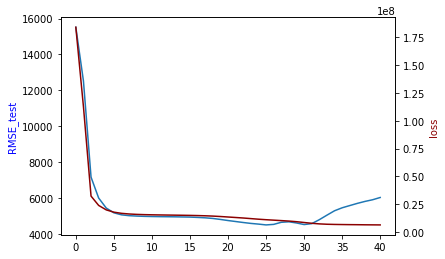

------------------------------------------
dropout = False
batchnorm = False
Количество батчей 2

МИНИМАЛЬНЫЙ ДОСТИГНУТЫЙ RMSE = 4799.111


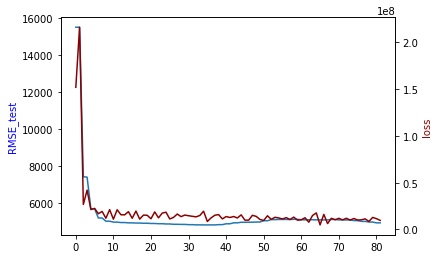

------------------------------------------
dropout = False
batchnorm = True
Количество батчей 1

МИНИМАЛЬНЫЙ ДОСТИГНУТЫЙ RMSE = 4483.0376


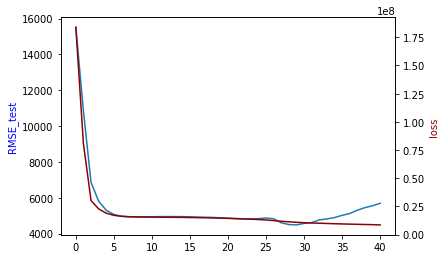

------------------------------------------
dropout = False
batchnorm = True
Количество батчей 2

МИНИМАЛЬНЫЙ ДОСТИГНУТЫЙ RMSE = 4483.0996


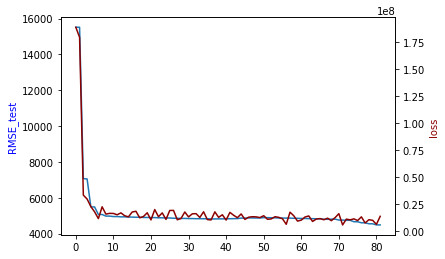

------------------------------------------
dropout = True
batchnorm = False
Количество батчей 1

МИНИМАЛЬНЫЙ ДОСТИГНУТЫЙ RMSE = 4407.6396


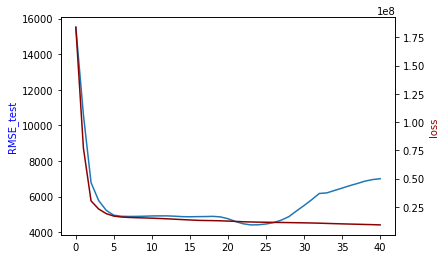

------------------------------------------
dropout = True
batchnorm = False
Количество батчей 2

МИНИМАЛЬНЫЙ ДОСТИГНУТЫЙ RMSE = 4793.29


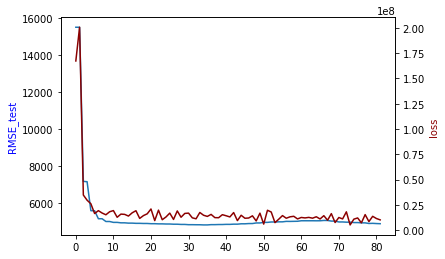

------------------------------------------
dropout = True
batchnorm = True
Количество батчей 1

МИНИМАЛЬНЫЙ ДОСТИГНУТЫЙ RMSE = 4460.55


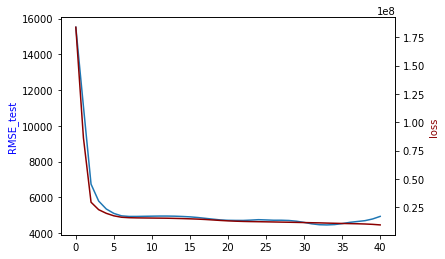

------------------------------------------
dropout = True
batchnorm = True
Количество батчей 2

МИНИМАЛЬНЫЙ ДОСТИГНУТЫЙ RMSE = 4736.575


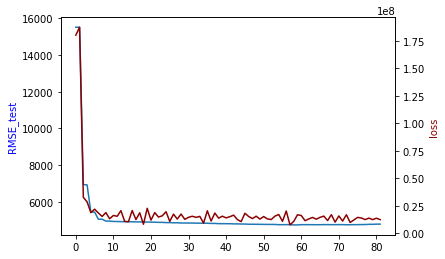

In [96]:
for dropout_onoff in [False, True]:
    for batchnorm_onoff in [False, True]:
        for N_batch in [1, 2]:
            
            net2 = Net2(n_in_neurons, n_hidden_neurons_1, n_hidden_neurons_2, n_hidden_neurons_3, 
            n_out_neurons, dropout_onoff, batchnorm_onoff)
            
            #размер батча. Есть 168 обучающих строк, значит размер батча не должен быть большим.
            batch_size = int(168/N_batch)
            num_batches = int(np.ceil(len(x_train)/batch_size))
            
            #выбор оптимизатора
            optimizer2 = torch.optim.Adam(net2.parameters(), lr=5.0e-3)
            
            min_rmse = 1e33 #задаём минимальный РМСЕ большим числом

            los2 = []
            rmse2 = []

            for epoch in range(num_epochs):
                order = np.random.permutation(len(x_train)) # случайная перестановка индексов объектов
                for batch_idx in range(num_batches):
                    start_index = batch_idx * batch_size # расчет номер стартового объекта батча
                    optimizer2.zero_grad()
  
                    batch_indexes = order[start_index:start_index+batch_size] # индексы объектов текущего батча
                
                    x_batch = x_train[batch_indexes]
                    y_batch = y_train[batch_indexes]
  
                    preds = net2.forward(x_batch, dropout_onoff, batchnorm_onoff).flatten()
                
                    loss_value = loss(preds, y_batch)

                    loss_value.backward()
                
                    optimizer2.step()
                            
                    if epoch % 100 == 0 or epoch == num_epochs - 1:
                        #print('loss =', loss_value.item()/1e6, 'млн.')
                        #print()
                        los2.append(loss_value.item())
        
                        net2.eval()
                        test_preds = net2.forward(x_test, dropout_onoff, batchnorm_onoff)
                        rmse_accuracy = np.sqrt(mean_squared_error(y_test.detach().numpy(), test_preds.detach().numpy()))
        
                        rmse2.append(rmse_accuracy)
        
                        if rmse_accuracy < min_rmse: #сохранение минимально достигнутого РМСЕ
                            min_rmse = rmse_accuracy
        
#                        print('epoch =', epoch, 'RMSE =', rmse_accuracy)
        
            print('------------------------------------------')
            print('dropout =', dropout_onoff)
            print('batchnorm =', batchnorm_onoff)
            print('Количество батчей', N_batch)
            print()
            print('МИНИМАЛЬНЫЙ ДОСТИГНУТЫЙ RMSE =', min_rmse)

    
            show_loss_rmse(rmse2, los2)

In [109]:
#функция расчета rmse
def rmse_scor(y_true, y_pred):
    return mean_squared_error(y_true, y_pred, squared=False)

In [110]:
rmse_score = make_scorer(rmse_scor)

In [111]:
#начальная инициализация параметров
dropout_onoff = False
batchnorm_onoff = False

In [112]:
n_in_neurons = x_train.shape[1] #количество входов на первый слой
n_hidden_neurons_1 = 32
n_hidden_neurons_2 = 30
n_hidden_neurons_3 = 14
n_out_neurons = 1

In [113]:
from skorch.callbacks import EpochScoring, EarlyStopping
skorch_regressor = NeuralNetRegressor(module=Net2, 
                                      device='cpu',  
                                      verbose=3,
                                      batch_size=batch_size,
                                      optimizer=torch.optim.Adam, 
                                      max_epochs=2500, 
                                      lr=5e-3, #шаг оптимизатора
                                      #train_split=ValidSplit(cv=5),
                                      criterion =nn.MSELoss,
                                      callbacks=[
                ('val_rmse', EpochScoring(scoring=rmse_score, lower_is_better=True, name='RMSE')),
                ('estoper', EarlyStopping( lower_is_better=True, monitor='RMSE')),
            ],
                                     ) 

In [114]:

params = {'module__n_in_neurons': [n_in_neurons], 
          'module__n_hidden_neurons_1': [n_hidden_neurons_1], 
          'module__n_hidden_neurons_2': [n_hidden_neurons_2], 
          'module__n_hidden_neurons_3': [n_hidden_neurons_3], 
          'module__n_out_neurons': [n_out_neurons], 
          'module__dropout_onoff': [False, True], 
          'module__batchnorm_onoff': [False, True]
        }

In [115]:
grid = RandomizedSearchCV(skorch_regressor, params, cv=3, scoring="neg_root_mean_squared_error", verbose=3) 
grid.fit(x_train, y_train.reshape(-1,1)) 
    

Fitting 3 folds for each of 4 candidates, totalling 12 fits
  epoch        RMSE      train_loss      valid_loss     dur
-------  ----------  --------------  --------------  ------
      1  15893.8506  204733544.6292  252614480.0000  0.0132
      2  15893.8506  204733544.6292  252614480.0000  0.0071
      3  15893.8506  204733544.6292  252614480.0000  0.0049
      4  15893.8506  204733544.6292  252614480.0000  0.0044
      5  15893.8506  204733544.6292  252614480.0000  0.0048
Stopping since RMSE has not improved in the last 5 epochs.
[CV 1/3] END module__batchnorm_onoff=False, module__dropout_onoff=False, module__n_hidden_neurons_1=32, module__n_hidden_neurons_2=30, module__n_hidden_neurons_3=14, module__n_in_neurons=15, module__n_out_neurons=1;, score=-11083.886 total time=   0.1s
  epoch        RMSE      train_loss      valid_loss     dur
-------  ----------  --------------  --------------  ------
      1  11876.9160  165147121.0787  141061136.0000  0.0067
      2  11875.6201  1651128

RandomizedSearchCV(cv=3,
                   estimator=<class 'skorch.regressor.NeuralNetRegressor'>[uninitialized](
  module=<class '__main__.Net2'>,
),
                   param_distributions={'module__batchnorm_onoff': [False,
                                                                    True],
                                        'module__dropout_onoff': [False, True],
                                        'module__n_hidden_neurons_1': [32],
                                        'module__n_hidden_neurons_2': [30],
                                        'module__n_hidden_neurons_3': [14],
                                        'module__n_in_neurons': [15],
                                        'module__n_out_neurons': [1]},
                   scoring='neg_root_mean_squared_error', verbose=3)

In [97]:
#расчёт RMSE на основе закона Стефана-Больцмана
mean_squared_error(ming_xing['temperature_k'], ming_xing['t_bolcman'], squared=False)

8917.686056513578

## Выводы

Получены следующие результаты:

    - RMSE рассчитанная через закон Стефана-Больцмана для всего датасета составляет около 8900 К.

    - базовая нейросеть не достигает RMSE около 3800 К и это в два раза лучше чем даёт расчёт через закон Стефана-Больцмана.
    
    - попытки улучшения нейросети даёт RMSE около 4400.
    Лучший результат при следующих параметрах:
        dropout = True
        batchnorm = False
        Количество батчей 1

        МИНИМАЛЬНЫЙ ДОСТИГНУТЫЙ RMSE = 4407.6396